In [1]:
from langgraph.graph import StateGraph, END
import pandas as pd

import sys

# Save the original sys.path
original_sys_path = sys.path.copy()

try:
    # Add the src directory to the system path
    sys.path.append("../")
    from agents.document_loader import load_documents_and_generate_embeddings
    from agents.state_config import QAState
    from agents.question_generator import question_generation_pipeline
    from agents.answer_generator import answer_generator
    from agents.export_agent import export_agent
    from agents.context_gathering import context_gathering
finally:
    # Restore the original sys.path
    sys.path = original_sys_path

from langchain_openai import ChatOpenAI, OpenAIEmbeddings



Created PromptTemplate for simple_question: input_variables=['context', 'examples', 'instruction'] input_types={} partial_variables={} template='\n            Output only the question, with no additional words, labels, or comments. The result must contain nothing but the question itself.\n            {instruction}\n\n            Examples:\n            {examples}\n\n            Context: {context}\n\n            Generated Question:\n            '
Input variables: ['context', 'examples', 'instruction']


In [2]:
# Initialize the StateGraph with the state schema
graph = StateGraph(state_schema=QAState)

graph.add_node(
    "load_documents",
    load_documents_and_generate_embeddings,
    ),
graph.add_node("question_generation", question_generation_pipeline)
graph.add_node("context_gathering", context_gathering)
graph.add_node("answer_generation", answer_generator)
graph.add_node("export", export_agent)

# Set the Entry Point of the Graph
graph.set_entry_point("load_documents")

# Define Edges (Flow between Nodes)
graph.add_edge("load_documents", "question_generation")
graph.add_edge("question_generation", "context_gathering")
graph.add_edge("context_gathering", "answer_generation")
graph.add_edge("answer_generation", "export")
graph.add_edge("export", END)

# Compile the graph to create a runnable object
compiled_graph = graph.compile()

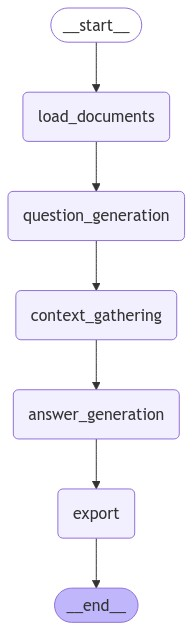

In [3]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [4]:
# Initialize Language Models
generator_llm = ChatOpenAI(model="gpt-4o")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()


def initialize_state(pdf_path):
    initial_state: QAState = {
        "pdf_path": pdf_path,
        "embedding_model": embeddings,
        "model": generator_llm,
        "critic_model": critic_llm,
        "documents": None,
        "document_embeddings": None,
        "questions": None,
        "evolved_questions": None,
        "answers": None,
        "contexts": None,
        "final_output": None,
        "max_evolved_questions": 20,
        "max_evolutions_per_technique": 1,
    }
    return initial_state

In [5]:
def run_qa_process(pdf_path):
    input_data = initialize_state(pdf_path)
    output = compiled_graph.invoke(input_data)
    return output

In [6]:
pdf_path = "https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf"
qa_output = run_qa_process(pdf_path)

Validating question:  {'id': '659594f2-90dc-4e1d-9949-a16a55064ace_simple_question_a0ebea6b', 'original_question_id': '659594f2-90dc-4e1d-9949-a16a55064ace', 'evolved_question': "What was the outcome of the General Court's decision regarding the European Commission's State Aid Decision?", 'evolution_type': 'simple_question'}
Result: {'Independence': 2, 'Clear Intent': 2}
Validating question:  {'id': 'f4e3b631-4ba3-44e8-9052-b9fb0e8ffee7_reasoning_question_e9ba0290', 'original_question_id': 'f4e3b631-4ba3-44e8-9052-b9fb0e8ffee7', 'evolved_question': "What was the outcome of the European Commission's State Aid Decision and its subsequent appeals involving the Company and Ireland?", 'evolution_type': 'reasoning_question'}
Result: {'Independence': 2, 'Clear Intent': 2}
Validating question:  {'id': 'fafaf140-e8d5-42f6-bb2e-b9d39e22f199_multi_context_question_3965151d', 'original_question_id': 'fafaf140-e8d5-42f6-bb2e-b9d39e22f199', 'evolved_question': 'What measures does the Company take to

In [7]:
# Display the resulting DataFrame
import pandas as pd

#pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(qa_output["final_output"])

In [8]:
df.columns

Index(['id', 'evolution_type', 'answer', 'contexts', 'evolved_question'], dtype='object')

In [10]:
pd.set_option('display.max_colwidth', None)
df[["id", "evolution_type", "evolved_question"]]

,id,evolution_type,evolved_question
0,659594f2-90dc-4e1d-9949-a16a55064ace_simple_question_a0ebea6b,simple_question,What was the outcome of the General Court's decision regarding the European Commission's State Aid Decision?
1,f4e3b631-4ba3-44e8-9052-b9fb0e8ffee7_reasoning_question_e9ba0290,reasoning_question,What was the outcome of the European Commission's State Aid Decision and its subsequent appeals involving the Company and Ireland?
2,fafaf140-e8d5-42f6-bb2e-b9d39e22f199_multi_context_question_3965151d,multi_context_question,What measures does the Company take to protect its term debt or marketable securities from fluctuations in interest rates?
3,78d956d7-77ff-425c-9517-b3ec24574b26_conversational_question_64c2831b,conversational_question,"What is the total comprehensive income for Apple Inc. for the three months ended June 29, 2024?"
4,905167dd-8696-4e67-b6ce-896253b5adeb_contextual_question_3e30c595,contextual_question,"What are the changes in unrealized gains and losses on derivative instruments and marketable debt securities reported by Apple Inc. for the three and nine months ended June 29, 2024, and July 1, 2023?"
5,05b6ab94-0a82-4ecc-9540-1d759dd98a91_counterfactual_question_ae04f01d,counterfactual_question,What were the primary drivers for changes in net sales across different regions in the third quarter and first nine months of 2024 compared to 2023?
6,7e71b1f2-05a5-4212-8bfc-44ef4c86cd10_temporal_reasoning_question_cd0c40da,temporal_reasoning_question,"What is the ending balance of total shareholders’ equity for Apple Inc. as of June 29, 2024?"
7,ede1c33c-e4bc-4a45-9fd4-25d7a4fb0d2e_multi_step_logical_deduction_8189e944,multi_step_logical_deduction,What legal challenges is the Company currently facing under the European Union's Digital Markets Act?
8,eadd5cba-d071-4bb4-9910-30a51f1738e9_hypothetical_scenario_generation_c945bd62,hypothetical_scenario_generation,"What were the ending balances of cash, cash equivalents, and restricted cash for Apple Inc. in the nine months ended June 29, 2024, and July 1, 2023?"
9,62495e3f-db7e-4ef1-bb85-3c60eeb45cda_mathematical_quantitative_reasoning_8474fcdb,mathematical_quantitative_reasoning,"What is the total comprehensive income for Apple Inc. for the nine months ended June 29, 2024?"


In [9]:
df[["id", "evolution_type", "evolved_question", "answer", "contexts"]]

,id,evolution_type,evolved_question,answer,contexts
0,659594f2-90dc-4e1d-9949-a16a55064ace_simple_qu...,simple_question,What was the outcome of the General Court's de...,The General Court's decision regarding the Eur...,[Note 6 – Income Taxes\nEuropean Commission St...
1,f4e3b631-4ba3-44e8-9052-b9fb0e8ffee7_reasoning...,reasoning_question,What was the outcome of the European Commissio...,The outcome of the European Commission's State...,[Note 6 – Income Taxes\nEuropean Commission St...
2,fafaf140-e8d5-42f6-bb2e-b9d39e22f199_multi_con...,multi_context_question,What measures does the Company take to protect...,To protect its term debt or marketable securit...,[Interest Rate Risk\nTo protect the Company’s ...
3,78d956d7-77ff-425c-9517-b3ec24574b26_conversat...,conversational_question,What is the total comprehensive income for App...,"For the three months ended June 29, 2024, Appl...",[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...
4,905167dd-8696-4e67-b6ce-896253b5adeb_contextua...,contextual_question,What are the changes in unrealized gains and l...,"For the periods ending June 29, 2024, and July...",[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...
5,05b6ab94-0a82-4ecc-9540-1d759dd98a91_counterfa...,counterfactual_question,What were the primary drivers for changes in n...,The primary drivers for changes in net sales a...,[Segment Operating Performance\nThe following ...
6,7e71b1f2-05a5-4212-8bfc-44ef4c86cd10_temporal_...,temporal_reasoning_question,What is the ending balance of total shareholde...,"As of June 29, 2024, the ending balance of tot...",[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...
7,ede1c33c-e4bc-4a45-9fd4-25d7a4fb0d2e_multi_ste...,multi_step_logical_deduction,What legal challenges is the Company currently...,The Company is currently facing significant le...,[PART II — OTHER INFORMATION\nItem 1. \nLega...
8,eadd5cba-d071-4bb4-9910-30a51f1738e9_hypotheti...,hypothetical_scenario_generation,"What were the ending balances of cash, cash eq...","For the nine months ended June 29, 2024, Apple...",[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...
9,62495e3f-db7e-4ef1-bb85-3c60eeb45cda_mathemati...,mathematical_quantitative_reasoning,What is the total comprehensive income for App...,The total comprehensive income for Apple Inc. ...,[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...


In [9]:
qa_output

{'pdf_path': 'https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf',
 'embedding_model': OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x14752bf50>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x147545d00>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True),
 'model': ChatOpenAI(client=<openai.resources.chat